In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
from hermes3.selectors import *
from pathlib import Path
from hermes3.utils import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

In [2]:
### Load dataset
casepath = Path('/home/mike/work/cases/dev-targetpump/targetpump_allpump')
gridpath = Path('/home/mike/work/cases/grid_test2_allpump.nc')

ds = xhermes.open_hermesdataset(
    datapath = Path(casepath) / "BOUT.dmp.*.nc",
    inputfilepath = Path(casepath) / "BOUT.inp",
    gridfilepath = Path(gridpath),
    unnormalise = False,
    geometry = "toroidal",
    keep_xboundaries = True,
    keep_yboundaries = True
)

ds = ds.hermes.extract_2d_tokamak_geometry()

ds = ds.load()
if "t" in ds.sizes:
    ds = ds.isel(t=-1)
m = ds.metadata

/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(


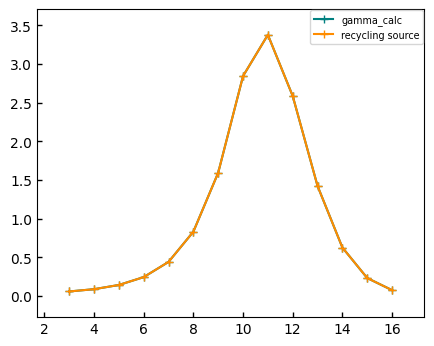

In [5]:

name = "outer_lower_target"
xslice = slice(3,-3)
i_index = xhermes.slice_poloidal(ds, name)

if name == "outer_lower_target":
    g_index = i_index + 1
elif name == "outer_upper_target":
    g_index = i_index - 1

i = (xslice, i_index)
g = (xslice, g_index)
reg = ds.hermes.select_region(name).isel(x=slice(1,-1))

def at_sheath(f, i, g):
    """
    Linear interpolation between final and guard cell.
    f = field, i = final cell slice, g = guard cell slice.
    """
    f = f.values
    return 0.5 * (f[i] + f[g])

# Options
options = ds.options
gamma_e = options["sheath_boundary_simple"]["gamma_e"]
gamma_i = options["sheath_boundary_simple"]["gamma_i"]

# Geometry and physics
params = ["J", "g_22", "dx", "dy", "dz", "dv", "dl", "dtor",
              "Ne", "Nd", "Vd+", "Td"]
d = {}
for param in params:
    d[param] = ds[param].values


# Sources from flow diagnostics
energy_flow_src_total = (ds["efd+_tot_ylow"].values[g] * -1 ) / reg["dv"]
energy_flow_src_advection = (ds["efd+_adv_ylow"].values[g] * -1 ) / reg["dv"]
energy_flow_src_conduction = (ds["efd+_cond_ylow"].values[g] * -1 ) / reg["dv"]

# Source from flow diagnostic in recycling
energy_flow_src_recycling = ds["debug"].values[i]

# Sources from gamma calc
nesheath = at_sheath(ds["Ne"], i, g)
tisheath = at_sheath(ds["Td+"], i, g)
visheath = at_sheath(ds["Vd+"], i, g)
daparsheath = (d["J"][i] + d["J"][g]) / (np.sqrt(d["g_22"][i]) + np.sqrt(d["g_22"][g])) * 0.5 * (d["dx"][i] + d["dx"][g]) * 0.5 * (d["dz"][i] + d["dz"][g])

gamma_calc = (gamma_i * nesheath * tisheath * visheath) * daparsheath / reg["dv"] 

fig, ax = plt.subplots(dpi = 100)

# ax.plot(reg["x"], reg["Ed+_sheath"], marker = "o", label = "Ed+_sheath")
# ax.plot(reg["x"], energy_flow_src_total, marker = "v", label = "efd+_tot_ylow")
# ax.plot(reg["x"], energy_flow_src_advection, marker = "+", label = "efd+_adv_ylow")
ax.plot(reg["x"], gamma_calc, marker = "+", label = "gamma_calc")
ax.plot(reg["x"], energy_flow_src_recycling, marker = "+", label = "recycling source")
ax.legend(fontsize = "x-small")
# ax.plot(reg["x"], reg["Ed+_recycle"], marker = "o")

In [4]:
reg["debug"].values

array([0.05826951, 0.08780682, 0.14215002, 0.24379595, 0.44021204,
       0.83120744, 1.59348243, 2.84358397, 3.37755828, 2.58609784,
       1.42244796, 0.62638355, 0.23186718, 0.07538676])